# Курсовой проект #1

## Прогнозирование цены на квартиру в Москве по имеющимся характеристикам

Описание файлов с данными:

* train.csv - данные для обучения модели
* test.csv - данные для тестирования и оценки обученной модели
* sampleSubmission.csv - пример отчетного файла в требуемом формате

Описание полей в таблице данных:

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

Загрузка библиотек

In [108]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

Загрузка датасета

In [109]:
# DATA_PATH_DIRECTORY = '/real-estate-price-prediction-moscow/'
raw_train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Класс с методами предобработки данных.
Включает в себя уменьшение размера памяти из лекций.

* Очистка:
    * Убираем все неправильные года. Заменяем их на произвольный 2000. Этих случаев мало, поэтому не страшно.
    * Если площадь кухни слишком большая, значит, скорее всего ошибка в данных. Заменим на примерную. Я смотрела отношение, как-то так и есть. Этих строк тоже мало.
    * С площадью то же самое. Их тоже мало, можно просто разделить. Там ошибка скорее всего.
    * С комнатами - то же. Если очень много, значит опечатка. Тоже посмотрела, примерно такое отношение площадь/комнаты.
    * И замена всех категориальных численными. Просто по словарю. В данном случае так вполне сойдет.
* fix_life_square метод подгона пропущенных данных в поле LifeSquare. Использую gradientBoostingRegressor.
* fix_healhcare_1 то же самое для соотвествующего поля

In [110]:
class Preprocessor:
    """Предобработка данных"""


    def __init__(self):
        self.features = []
        self.replace_dict = {'A': 1, 'B': 0}
        self.gbr_LifeSquare = 0
        self.gbr_hc1 = 0

    def show_distribution(self, df, col):
        """"""

        sns.displot(df[col], height=5, aspect=1.5, bins=14, kde=True)
        plt.title(col + ' Distribution')

    @staticmethod
    def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
        """ iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.
        """
        start_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df

    def clear(self, df):

        df = self.reduce_mem_usage(df)

        df.loc[df['HouseYear'] > 2022, 'HouseYear'] = 2000

        df.loc[df['KitchenSquare'] > 100, 'KitchenSquare'] =\
            (df['Square'] / 7).__round__()

        df.loc[df['Square'] > 500, 'Square'] = df['Square'] / 10

        df.loc[(df['Rooms'] == 0) | (df['Rooms'] > 6), 'Rooms'] =\
            (df['Square'] / 30).__round__()

        df.replace(self.replace_dict, inplace=True)

        return df

    # def fill_na_LifeSquare(self, X):
    #
    #     return self.gbr_LifeSquare.predict(X)
    #
    # def fill_na_Healthcare1(self, X):
    #
    #     return self.gbr_hc1.predict(X)

    def fix_life_square(self, df):

        mask = df['LifeSquare'].isna()
        mask2 = df['LifeSquare'] > 100

        x_cols = ['Square', 'HouseYear', 'KitchenSquare', 'Social_1', 'Ecology_1']

        X_ls = df.loc[~(mask | mask2), x_cols]
        y_ls = df.loc[~(mask | mask2), 'LifeSquare']

        if not self.gbr_LifeSquare:
            self.gbr_LifeSquare = GradientBoostingRegressor(criterion='squared_error',
                                                            max_depth=5,
                                                            min_samples_leaf=5,
                                                            random_state=42,
                                                            n_estimators=200)
            self.gbr_LifeSquare.fit(X_ls, y_ls)

        y_ls_pred = self.gbr_LifeSquare.predict(X_ls)
        print('R2 for LifeSquare training set: ' + str(r2_score(y_ls, y_ls_pred)))

        df.loc[mask | mask2, 'LifeSquare'] = self.gbr_LifeSquare.predict(
            df.loc[mask | mask2, x_cols])

        sns.displot(df['LifeSquare'], height=5, aspect=1.5, bins=14)

        return df

    def fix_healthcare_1(self, df):

        mask = df['Healthcare_1'].isna()

        cols = ['DistrictId', 'HouseYear', 'Shops_1', 'Helthcare_2']

        X_hc1 = df.loc[~mask, cols]
        y_hc1 = df.loc[~mask, 'Healthcare_1']

        if not self.gbr_hc1:
            self.gbr_hc1 = GradientBoostingRegressor(criterion='squared_error',
                                                     max_depth=5,
                                                     min_samples_leaf=5,
                                                     random_state=21,
                                                     n_estimators=300)
            self.gbr_hc1.fit(X_hc1, y_hc1)

        y_hc1_pred = self.gbr_hc1.predict(X_hc1)

        print('R2 for Healthcare_1 training set: ' + str(r2_score(y_hc1, y_hc1_pred)))

        df.loc[mask, 'Healthcare_1'] = self.gbr_hc1.predict(df.loc[mask, cols])

        sns.displot(df['Healthcare_1'], height=5, aspect=1.5, bins=14)

        return df

Вспомогательный класс, которые содержит методы, добавляющие признаки.

In [111]:
class Features:

    def __init__(self, df):
        self.counter = 0
        self.groups = []
        self.district_size_df = 1
        self.kmeans = 0

    def add_price_per_meter(self, df):

        df['Price/m2'] = df['Price'] / df['Square']
        df.loc[df['Price/m2'] > 10000, 'Price/m2'] = df['Price/m2'].median()

        return df

    @staticmethod
    def display_clusters_distribution(unique, counts):
        """Визуализация распределения классов по кластерам"""
        plt.figure(figsize=(8,5))

        plt.bar(unique, counts)

        plt.xlabel('Clusters')
        plt.xticks(unique)
        plt.ylabel('Count')
        plt.title('Clusters distribution')
        plt.show()

    def add_district_size(self, df):

        if isinstance(self.district_size_df, int):
            self.district_size_df = df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

        df = df.merge(self.district_size_df, on='DistrictId', how='left')
        df.loc[df['DistrictSize'] < 10, 'DistrictId'] = -1
        df['DistrictSize'].fillna(-1, inplace=True)

        return df

    def new(self, col_1, col_2, df):

        new_col_name = 'Med' + str(self.counter) + col_2

        groupdf = df.groupby(col_1, as_index=False).agg({col_2: 'median'}).\
            rename(columns={col_2: new_col_name})
        self.groups.append(groupdf)

        df = df.merge(groupdf, on=col_1, how='left')
        df[new_col_name].fillna(df[new_col_name].median(), inplace=True)

        self.counter += 1

        return df

    def append_all_added_features(self, df_1):

        for i in range(len(self.groups)):
            col_name = self.groups[i].columns.to_list()
            df_1 = df_1.merge(self.groups[i], on=col_name[:-1], how='left')
            df_1[col_name[-1]].fillna(df_1[col_name[-1]].median(), inplace=True)

        return df_1

    def clusterize_kmeans(self, df):

        # cols_4_kmeans = ['DistrictId', 'Square', 'LifeSquare', 'KitchenSquare']
        cols_4_kmeans = ['Med3Price/m2']

        scaler = RobustScaler()
        df_scaled = scaler.fit_transform(df.drop(['Price', 'Price/m2'], axis=1))

        if not self.kmeans:
            self.kmeans = KMeans(n_clusters=7, random_state=36)
            self.kmeans.fit(df_scaled)

        clust_kmeans = self.kmeans.predict(df_scaled)

        clusters_dummies = pd.get_dummies(clust_kmeans, drop_first=True, prefix='clusters_')

        df = pd.concat([df, clusters_dummies], axis=1)

        unique, counts = np.unique(clust_kmeans, return_counts=True)
        self.display_clusters_distribution(unique, counts)

        return df

    def clust_dbscan(self, df, eps=1):

        scaler = RobustScaler()
        df_scaled = scaler.fit_transform(df.drop(['Price', 'Price/m2'], axis=1))

        dbscan = DBSCAN(eps=eps, min_samples=50)
        labels_clast = dbscan.fit_predict(df_scaled)
        labels_clast = pd.Series(labels_clast, name='clusters_dbscan')
        clusters_dummies = pd.get_dummies(labels_clast, drop_first=True, prefix='clusters_')

        df = pd.concat([df, clusters_dummies], axis=1)

        unique, counts = np.unique(labels_clast, return_counts=True)
        self.display_clusters_distribution(unique, counts)

        return df

Класс, описывающий модель.

In [112]:
class Model:

    def __init__(self):

        self.gbr_model = GradientBoostingRegressor(criterion='squared_error',
                                                   max_depth=5,
                                                   min_samples_leaf=5,
                                                   random_state=21,
                                                   n_estimators=200)

    def fit(self, X, y):

        self.columns = X.columns
        self.gbr_model.fit(X, y)

    def cross_val(self, X, y):

        cv_score = cross_val_score(self.gbr_model,
                                   X,
                                   y,
                                   scoring='r2',
                                   cv=KFold(n_splits=7, shuffle=True, random_state=21))

        print('CrossVal mean value: ', np.mean(cv_score))

    def predict(self, X):

        return self.gbr_model.predict(X)

    def show_feature_importances(self):

        feature_importances = pd.DataFrame(zip(self.columns, self.gbr_model.feature_importances_),
                                           columns=['feature_name', 'importance'])

        print(feature_importances.sort_values(by='importance', ascending=False))

    def r2(self, y_true, y_pred):

        print('R2 : ' + str(r2_score(y_true, y_pred)))

    @staticmethod
    def create_csv(y_pred, overwrite=False):

        result = pd.DataFrame(y_pred, columns=['Price'])
        result.set_index(test_data['Id'], inplace=True)

        print(result)

        if overwrite:
            result.to_csv('AllaMaksina_predictions_32987.csv')

In [113]:
df = raw_train_data.copy()
temp_df = df.select_dtypes(include='object')
temp_df.describe()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [114]:
for col in temp_df.columns.tolist():
    print(temp_df[col].unique())

['B' 'A']
['B' 'A']
['B' 'A']


Видно, что есть 3 категориальных поля и остальные количественные. Видно их распределение. Можно просто заменить по словарю.

Поле Id

In [115]:
df['Id'].nunique()

10000

Вряд ли оно на что-то влияет. Судя по названию, это просто идентификационный номер. Удалим его.

In [116]:
df.drop('Id', axis=1, inplace=True)

Создадим объект, который будет чистить данные.

In [117]:
preproc = Preprocessor()

In [118]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Если внимательно рассматривать данные, можно заметить, что есть несколько ошибок в указании года, площадей и, вероятно, комнат. Если комнат очень много, то это скорее всего ошибка. А если 0, то не известно. При детальном изучении можно заметить определенные отношения. Почистим данные.

In [119]:
df = preproc.clear(df)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.47 MB
Decreased by 67.7%


Посмотрим на распределение цены

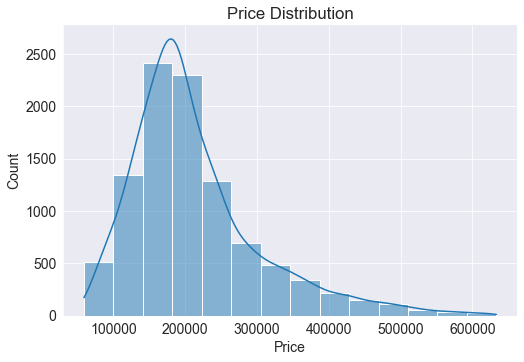

In [120]:
preproc.show_distribution(df, 'Price')

Вполне хорошее, без скачков и с 1 пиком. Несимметричное. С хвостом.

Создадим объект, который будет добавлять новые признаки

In [121]:
feat = Features(df)

Добавим цену за метр и объемы выборки по районам.

In [122]:
df = feat.add_price_per_meter(df)
df = feat.add_district_size(df)

Посмотрим на цену за метр. Ближе к нормальному. 2 пика.

Мне не удалось построить нормальную модель для предсказания цены за метр (при умножении на площадь эта ошибка в 0.1 соответственно увеличивается (Примерно раз в 5)).

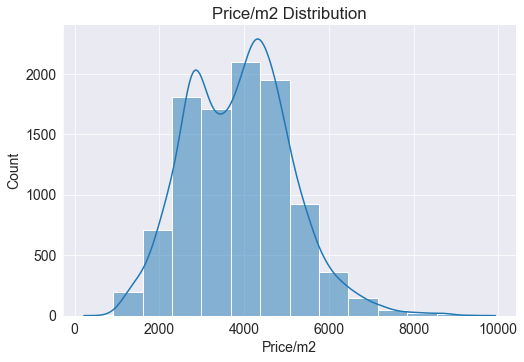

In [123]:
preproc.show_distribution(df, 'Price/m2')

Посмотрим, сколько NA значений в датасете

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   LifeSquare     7887 non-null   float32
 4   KitchenSquare  10000 non-null  float32
 5   Floor          10000 non-null  int8   
 6   HouseFloor     10000 non-null  float32
 7   HouseYear      10000 non-null  int32  
 8   Ecology_1      10000 non-null  float32
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int8   
 12  Social_2       10000 non-null  int16  
 13  Social_3       10000 non-null  int16  
 14  Healthcare_1   5202 non-null   float32
 15  Helthcare_2    10000 non-null  int8   
 16  Shops_1        10000 non-null  int8   
 17  Shops_2        10000 non-null  int64  
 18  Price  

Страдают LifeSquare и Healthcare_1. Много пропусков. В тестовом наборе процент пропусков примерно такой же. Поэтому надо как-то лечить.

Специально для них есть 2 функции, которые пытаются адекватно закрыть эти дыры. Они же показывают R2 score для этих предсказаний по обучающим данным и распределение. Для LifeSquare маловато, но лучше, чем медианное значение.

Гистограммы показывают, как признаки распределены. Если заменять медианой или каким-либо конкретным значением, то будет один большой пик на фоне нормального распределения. Это не очень хорошо.

R2 for LifeSquare training set: 0.7861245256489092


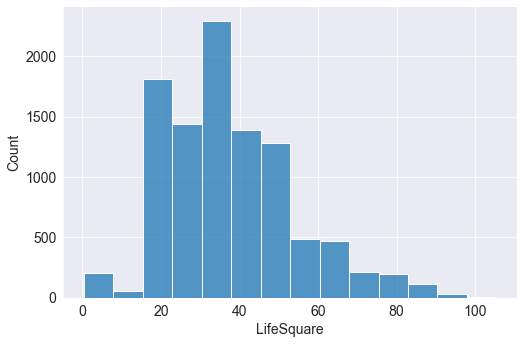

In [125]:
df = preproc.fix_life_square(df)

R2 for Healthcare_1 training set: 0.9745970404875988


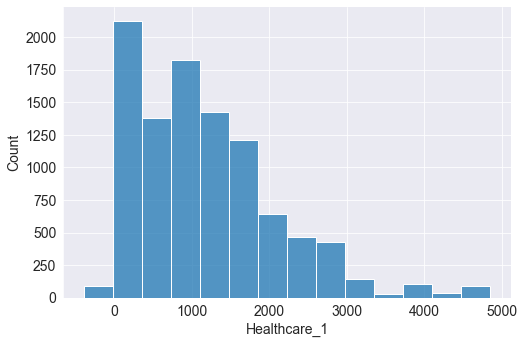

In [126]:
df = preproc.fix_healthcare_1(df)

Добавим несколько новых признаков. Это признаки на основе groupby и price: median в качестве аггрегационной функции.
Это даст примерное представление о ценах по выбранным признакам.

In [127]:
df = feat.new(['Ecology_1', 'Ecology_2', 'Ecology_3'], 'Price', df)
df = feat.new(['DistrictId', 'Rooms'], 'Price/m2', df)
df = feat.new(['DistrictId', 'Social_2', 'Social_1'], 'Price', df)
df = feat.new(['Healthcare_1', 'Helthcare_2'], 'Price/m2', df)

Проверим, все ли в порядке

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   LifeSquare     10000 non-null  float32
 4   KitchenSquare  10000 non-null  float32
 5   Floor          10000 non-null  int8   
 6   HouseFloor     10000 non-null  float32
 7   HouseYear      10000 non-null  int32  
 8   Ecology_1      10000 non-null  float32
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int8   
 12  Social_2       10000 non-null  int16  
 13  Social_3       10000 non-null  int16  
 14  Healthcare_1   10000 non-null  float32
 15  Helthcare_2    10000 non-null  int8   
 16  Shops_1        10000 non-null  int8   
 17  Shops_2        10000 non-null  int64  
 18  Price  

Нет NA. Можно продолжать

In [129]:
# df = feat.clusterize_kmeans(df)

Сформируем обучающие данные.

In [130]:
X = df.drop(['Price', 'Price/m2'], axis=1)
y = df['Price']

Создадим GradientBoostingRegressor. Был проведен GridSearch. Лучшие параметры спрятаны в объекте.

In [131]:
model = Model()

In [132]:
# model.cross_val(X, y)

In [133]:
model.fit(X, y)

Посмотрим на важность признаков. Интересно, что добавленные признаки оказались важнее, чем, например, непосредственно, количество комнат или год постройки.

In [134]:
model.show_feature_importances()

     feature_name  importance
2          Square    0.436269
22   Med3Price/m2    0.201758
21      Med2Price    0.174741
20   Med1Price/m2    0.065181
1           Rooms    0.024019
7       HouseYear    0.015631
6      HouseFloor    0.010754
3      LifeSquare    0.010493
13       Social_3    0.008505
5           Floor    0.008331
4   KitchenSquare    0.008301
19      Med0Price    0.006978
18   DistrictSize    0.005531
14   Healthcare_1    0.005384
8       Ecology_1    0.004388
0      DistrictId    0.003495
16        Shops_1    0.003404
12       Social_2    0.002990
11       Social_1    0.002877
15    Helthcare_2    0.000897
10      Ecology_3    0.000060
17        Shops_2    0.000013
9       Ecology_2    0.000000


Теперь тестовые данные. Все то же самое, только короче.

# Test data preprocessing

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%
R2 for LifeSquare training set: 0.6103142034944029
R2 for Healthcare_1 training set: 0.933876196936269


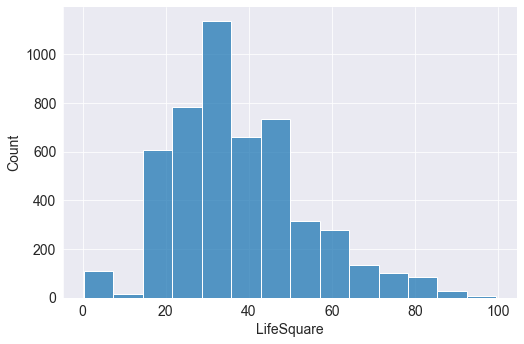

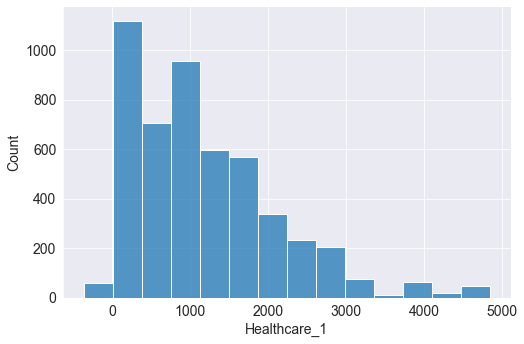

In [135]:
test_df = preproc.clear(test_data)

test_df = feat.add_district_size(test_df)

test_df = preproc.fix_life_square(test_df)
test_df = preproc.fix_healthcare_1(test_df)

test_df = feat.append_all_added_features(test_df)

In [136]:
# Проверка на отсутствие NA
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int16  
 1   DistrictId     5000 non-null   int16  
 2   Rooms          5000 non-null   float32
 3   Square         5000 non-null   float32
 4   LifeSquare     5000 non-null   float32
 5   KitchenSquare  5000 non-null   float32
 6   Floor          5000 non-null   int8   
 7   HouseFloor     5000 non-null   float32
 8   HouseYear      5000 non-null   int16  
 9   Ecology_1      5000 non-null   float32
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int8   
 13  Social_2       5000 non-null   int16  
 14  Social_3       5000 non-null   int16  
 15  Healthcare_1   5000 non-null   float32
 16  Helthcare_2    5000 non-null   int8   
 17  Shops_1        5000 non-null   int8   
 18  Shops_2 

In [137]:
y_pred = model.predict(test_df.drop('Id', axis=1))

In [138]:
model.create_csv(y_pred)

               Price
Id                  
4567   171586.011277
5925   122863.281647
960    139760.283182
3848   153778.535894
746    186407.719533
...              ...
10379  175514.025214
16138  361493.833582
3912   150772.370197
5722   193453.418416
11004  244627.704949

[5000 rows x 1 columns]


In [139]:
result = pd.DataFrame(y_pred, columns=['Price'])
result.set_index(test_data['Id'], inplace=True)
result

,Price
Id,
4567,171586.011277
5925,122863.281647
960,139760.283182
3848,153778.535894
746,186407.719533
...,...
10379,175514.025214
16138,361493.833582
3912,150772.370197


In [140]:
result.to_csv('AllaMaksina_predictions_20.csv')

In [141]:
# kaggle утверждает, что score = 0.76726

Все очень сырое. Нужно оформить. Много экспериментов было. Здесь только самое основное.